# Which asset best correlates with Gold Spot?

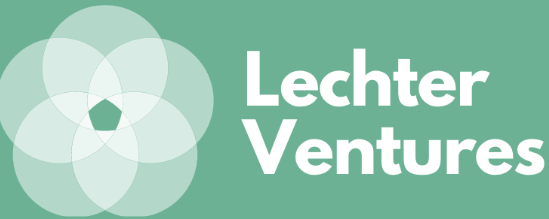

In [15]:
from IPython.display import display, Image
Image('Supplementary Files/Lechter Ventures Master.png')

----
#### Disclaimer
_The information summarised herein does not constitute financial or other professional advice and is general in nature. It does not take into account your specific circumstances and should not be acted on without full understanding of your current situation and future goals and objectives by a fully qualified financial advisor. In doing so you risk making commitments to a product and/or strategy that may not be suitable to your needs._

_Whilst I have tried to ensure the accuracy and completeness of the contents of this document, Lechter Ventures, LLC cannot offer any undertaking or guarantee, either expressly or implicitly, including liability towards third parties, regarding how correct, complete or up to date the contents of this document are. I reserve the right to supplement this document at any time or to change or delete any information contained or views expressed on this document._

_Lechter Ventures, LLC accepts no liability for any loss or damage howsoever arising out of the use of this document or reliance on the content of the document._

------------

### **TL;DR** 

If you would like to gain exposure into gold without having to physically own it or trade futures, the following ETF's appear to correlate well with price changes in gold spot: IAU, GLD, BAR, and SGOL. Before acting on these insights, Lechter Ventures plans on performing additional research into these ETF's to make sure we fully understand the risk of owning each.

Skip to the "Results and Conclusion" section for more details. If you have any additional questions/comments/concerns, please email me at LechterVentures@gmail.com.

### Context

Various trading peers and I have become more interested in gold as an investment vehicle given the unprecedented government intervention happening during the Coronavirus pandemic (this is covered in more detail in other parts). In order for us to gain exposure in the most efficient way, we need to find a liquid, tradable asset that tracks the spot price of gold well (amongst other factors, which are beyond the scope of this first exercise).

### Goal 

**Identify the ETF/futures/liquid tradable asset that best correlates with the Gold spot price.**

_One final note before getting started:_ There are a multitude of data sources for gold spot prices. Given some casual research calling my brokerage, speaking with folks on The Portal Discord server and chatting with some peers in the Finance industry, I have decided to use the gold price quotes from [kitco.com](kitco.com) here as my source of truth. While there are other potential alternatives (LBMA, APMEX), they lack an easy way to access historical data. And with this in mind, I do think it would be worthwhile to actually visit a couple physical gold vendors to confirm these are the best sources of truth.

If you don't care about the data iungestion and feature engineering, please skip to the "Results and Conclusions" section. With that out of the way, let's jump in!

------

### Import libraries and datasets

In [16]:
#Import libs
import ffn as f
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from datetime import timedelta, datetime
import pandas_datareader as pdr
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import warnings
import quandl

#to display visuals in notebook
%matplotlib inline
warnings.filterwarnings('ignore')
init_notebook_mode(connected = True)

#hack used to access yahoo finance data for pandas data manipulation
yf.pdr_override() 

In [17]:
#Ingest kitco dataset, perform simple modifications, and preview it
df_kitco = pd.read_csv('Supplementary Files/Untitled spreadsheet - Kitco.csv').rename(columns={'date':'Date'})
df_kitco['Date'] =  pd.to_datetime(df_kitco['Date'], format='%Y-%m-%d')
display(df_kitco.tail())

,Date,value
1105,2020-04-27,1725.0
1106,2020-04-28,1698.0
1107,2020-04-29,1710.9
1108,2020-04-30,1713.6
1109,2020-05-01,1687.0


We now need a list of gold tradable assets to compare with our spot data. In this analysis, I study 5 ETF's (IAU, GLD, SGDLX, BAR, SGOL) and the gold frontmonth futures contract (GC=F).

The list I include here is most likely not exhaustive, but comes from running a search for gold on my brokerage's trading platofrm and studying the various instruments discussed amongst more active members of the Eric Weinstein's Portal community.

In [18]:
#Create dataframe dictionary and identify the various gold tradable assets I'd like to study
dictionary_of_historical_assets = {}
assets_to_study = ['IAU', 'GLD', 'SGDLX', 'BAR', 'SGOL', 'GC=F'] #GC=F are gold futures, everything else is ETF's

#Iterate through the assets we want to study: store all historical data and then prep visual
for ticker in assets_to_study:
    
    #Create new dataframe for each ticker in my assets_to_study list. Also make date a column
    dictionary_of_historical_assets['df_' + ticker] = pdr.get_data_yahoo(ticker, interval='d')
    dictionary_of_historical_assets['df_' + ticker] = dictionary_of_historical_assets['df_' + ticker].reset_index()
    
    #Gold futures are missing trading data for a couple dates so I had to remove those
    if ticker == 'GC=F':
        dictionary_of_historical_assets['df_' + ticker] = \
        dictionary_of_historical_assets['df_' + ticker][(dictionary_of_historical_assets['df_' + ticker]['Volume'] != 0)]
    else:
        pass
        
    
    #Instantiate Candlestick visualization
    fig = go.Figure(data=[go.Candlestick(x=dictionary_of_historical_assets['df_' + ticker]['Date'],
                    open=dictionary_of_historical_assets['df_' + ticker]['Open'],
                    high=dictionary_of_historical_assets['df_' + ticker]['High'],
                    low=dictionary_of_historical_assets['df_' + ticker]['Low'],
                    close=dictionary_of_historical_assets['df_' + ticker]['Close'])])

    #Update layout cause yolo
    fig.update_layout(
                    title=dict(text = ticker,
                               x = 0.5,
                               font=dict(
                                        family="PT Sans Narrow",
                                        size=30,
                                        color="#7f7f7f"
                                        )
                              ),
                    xaxis_title='Time', yaxis_title='Price', hovermode = 'x', 
                    font=dict(
                                family="Courier New",
                                size=15,
                                color="#7f7f7f"
                                ),
                    legend=dict(
                                font=dict(
                                    family="Courier New",
                                    size=12,
                                    color="black"
                                         )
                               )

                    )

    #Display the graph
    fig.show()

### Data Manipulation / Feature Engineering

In [19]:
#We need to aggregate all asset data into a single dataframe.
# We now instantiate a new dataframe to do this, beginning with IAU data
df_IAU_clean = pd.DataFrame(dictionary_of_historical_assets['df_IAU'][['Date', 'Close']])
df_IAU_clean = df_IAU_clean.rename(columns={'Close':'IAU'})
df_gold_correlation_raw = df_IAU_clean

#Iterate through our assets we want to study and add their data to dataframe created above
for ticker in assets_to_study[1:]:
    dataframe = pd.DataFrame(dictionary_of_historical_assets['df_' + ticker][['Date', 'Close']])
    dataframe = dataframe.rename(columns={'Close':ticker})
    df_gold_correlation_raw = pd.merge(df_gold_correlation_raw, dataframe, on='Date')

#Add Kitco data and make sure everything looks ok
df_gold_correlation_raw = pd.merge(df_gold_correlation_raw, df_kitco, on='Date').rename(columns={'value':'Kitco'})
df_gold_correlation_raw.head()

,Date,IAU,GLD,SGDLX,BAR,SGOL,GC=F,Kitco
0,2017-09-01,12.75,126.059998,39.959999,13.2700,12.925,1324.500000,1324.4
1,2017-09-08,12.95,127.970001,40.730000,13.4973,13.054,1346.000000,1346.0
2,2017-09-15,12.70,125.529999,38.549999,13.2224,12.805,1320.400024,1319.2
3,2017-09-22,12.47,123.239998,37.660000,12.9740,12.569,1293.300049,1297.1
4,2017-09-29,12.31,121.580002,36.919998,12.8209,12.400,1281.500000,1279.4


In [20]:
#Breaking out Kitco and futures into one dataframe and all other assets in another.
#I do this because the nominal prices for these 2 groups are dramatically different,
#so I need to graph these data with 2 different sets of axes
assets_to_study_kitco = assets_to_study
assets_to_study_kitco.append('Kitco')

#Breaking out the 2 groups here
df_gold_correlation_raw_melt_with_kitco = pd.melt(df_gold_correlation_raw, id_vars=['Date'], 
                                  value_vars = assets_to_study_kitco)
df_gold_correlation_raw_melt_no_kitco_or_futures = \
    df_gold_correlation_raw_melt_with_kitco[(df_gold_correlation_raw_melt_with_kitco['variable'] != 'Kitco')
                                            & 
                                            (df_gold_correlation_raw_melt_with_kitco['variable'] != 'GC=F')]
df_gold_correlation_raw_melt_only_kitco_and_futures = \
    df_gold_correlation_raw_melt_with_kitco[(df_gold_correlation_raw_melt_with_kitco['variable'] == 'Kitco')
                                            | 
                                           (df_gold_correlation_raw_melt_with_kitco['variable'] == 'GC=F')]

#Making sure everything looks ok
display(df_gold_correlation_raw_melt_only_kitco_and_futures.head())

,Date,variable,value
870,2017-09-01,GC=F,1324.500000
871,2017-09-08,GC=F,1346.000000
872,2017-09-15,GC=F,1320.400024
873,2017-09-22,GC=F,1293.300049
874,2017-09-29,GC=F,1281.500000


### Results and Conclusion

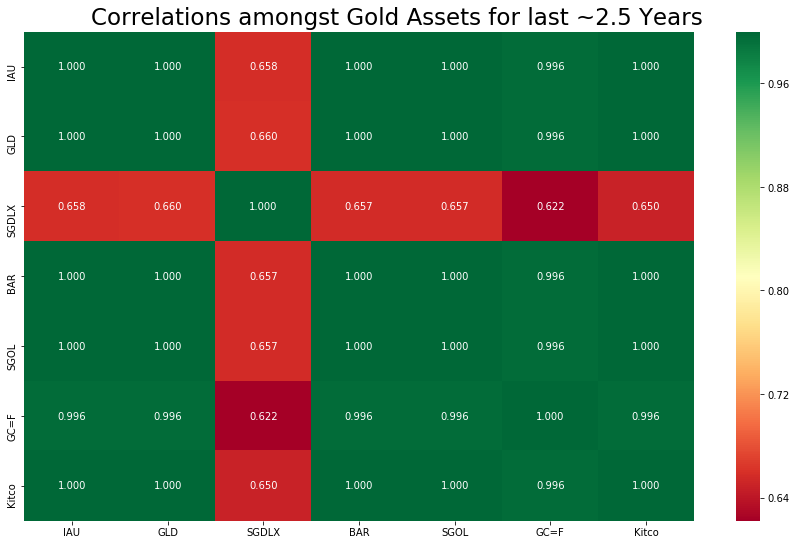

In [21]:
#Prepare and display heatmap data visualization
df_gold_correlation = round(df_gold_correlation_raw.corr(),3)
plt.figure(figsize = (15,9))
ax = sns.heatmap(df_gold_correlation, annot = True, cmap = 'RdYlGn', fmt = '.3f');
plt.text(x=0.7, y=-0.1, s='Correlations amongst Gold Assets for last ~2.5 Years', fontsize = 23);
bottom, top = ax.get_ylim();
ax.set_ylim(bottom + 0.5, top - 0.5);

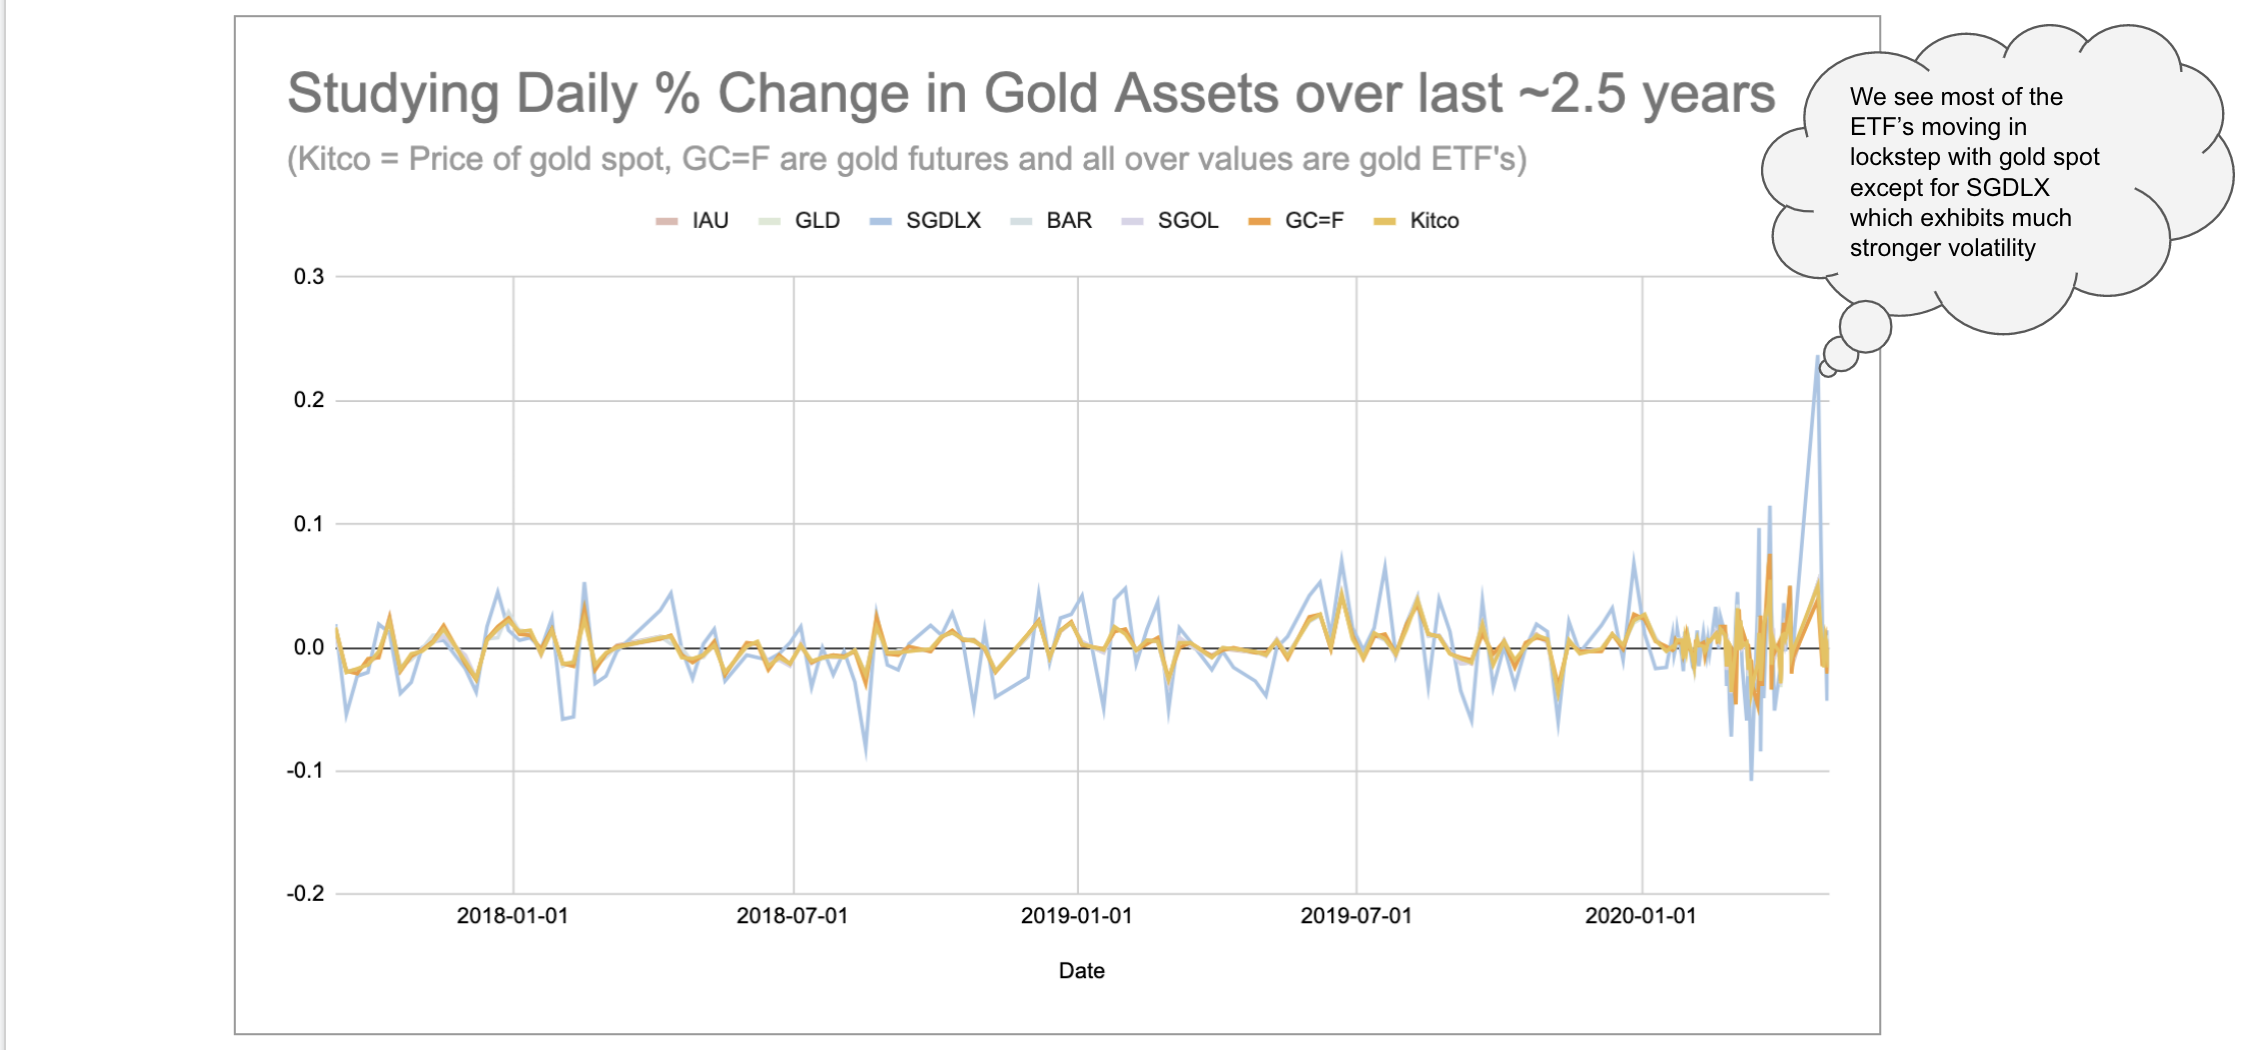

In [22]:
#Honestly Python can sometimes really suck for simple data visualizations
#so threw this together in Google Sheets using the above df_gold_correlation_raw dataframe
Image('Supplementary Files/Screen Shot 2020-05-04 at 11.56.53 AM.png')


    
The goal of this analysis was to identify the ETF/futures/liquid tradable asset that best correlates with the gold spot price. **We find that all of the assets we studied are almost perfectly correlated with Kitco, except for SGDLX.** Not only does this ETF not track gold as well as the other assets studied, but it also exhibits much strong historical volatility (probably the reason why it also has a low correlation with gold spot).

Only looking at the data here, Lechter Ventures recommends investing in IAU, GLD, BAR, and SGOL if you'd like an ETF that tracks well with the spot price of gold. **If you are a retail investor, Lechter Ventures would not recommend trading gold futures since there are some additional risks there that are not present in the ETF.**

There are some key considerations that should be called out for this analysis if you plan on acting on it:
- _Data limit:_ We only have data going back the last ~2.5 years. We would've ideally liked to have studied these trends further out, but this could not be accomplished here.
- _Data cleanup:_ There were 3 trading days of missing gold futures data which had to be removed from the analysis. While relatively insignificant given the extended timeframes studied, this could potentially alter our correlation calculations to reflect values that do not perfectly reflect trading activity during the timeframe studied. Additionally, a number of the gold spot indexes price gold each day on a "PM" or end-of-day settlement price. With this in mind, all the trading data studied for the ETF's and futures reflected the closing price for those securities on a given day. 
- _Validating source of truth:_ Given owning gold represents a holding that performs best during times of crisis, I think it's important to speak with actual pawn shops and other gold merchants to see what data they use to evaluate the daily spot price of gold. Armed with this information, I'd be happy to re-run these numbers to see how the results change.

The next step I'd like to take this with analysis is bulleted below.
- We have not studied the prospectuses of the ETF's in detail which is important in evaluating these assets. More specifically, I would like to better understand expenses, institutional responsibilty and detailed tracking procedure for all the ETF's studied here. With this additional work complete, Lechter Ventures will feel ready to invest more confidently.

Questions/comments/concerns? Please email me at LechterVentures@gmail.com.

### Appendix

In [23]:
#Demonstrating what gold futures look like without the data cleanup performed above
ticker = 'GC=F'
df_gc = pdr.get_data_yahoo(ticker, interval='d')
df_gc = df_gc.reset_index()

fig = go.Figure(data=[go.Candlestick(x=df_gc['Date'],
                open=df_gc['Open'],
                high=df_gc['High'],
                low=df_gc['Low'],
                close=df_gc['Close'])])

fig.update_layout(
                title=dict(text = ticker,
                           x = 0.5,
                           font=dict(
                                    family="PT Sans Narrow",
                                    size=30,
                                    color="#7f7f7f"
                                    )
                          ),
                xaxis_title='Time', yaxis_title='Price', hovermode = 'x', 
                font=dict(
                            family="Courier New",
                            size=15,
                            color="#7f7f7f"
                            ),
                legend=dict(
                            font=dict(
                                family="Courier New",
                                size=12,
                                color="black"
                                     )
                           )

                )

fig.show()

In [24]:
#If we do want to analyze the LBMA data, this is how we can easily ingest it
mydata = quandl.get("LBMA/GOLD")
display('Beginning of Dataset')
display(mydata.head())
display('End of Dataset')
display(mydata.tail())

'Beginning of Dataset'

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
Date,,,,,,
1968-01-02,35.18,NaN,14.641,NaN,NaN,NaN
1968-01-03,35.16,NaN,14.617,NaN,NaN,NaN
1968-01-04,35.14,NaN,14.603,NaN,NaN,NaN
1968-01-05,35.14,NaN,14.597,NaN,NaN,NaN
1968-01-08,35.14,NaN,14.586,NaN,NaN,NaN


'End of Dataset'

,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
Date,,,,,,
2020-04-28,1708.10,1691.55,1367.68,1357.98,1571.11,1559.27
2020-04-29,1706.00,1703.35,1371.97,1368.64,1569.69,1568.10
2020-04-30,1716.75,1702.75,1373.92,1361.69,1577.86,1568.91
2020-05-01,1673.05,1686.25,1332.08,1347.15,1523.14,1536.68
2020-05-04,1703.70,1709.10,1371.14,1374.63,1558.72,1563.83
